<a href="https://colab.research.google.com/github/LYX-AI/AI_Learning_Start_From_-Kaggle/blob/main/Getting_started_with_NLP_for_absolute_beginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

One area where deep learning has dramatically improved in the last couple of years is natural language processing (NLP). Computers can now generate text, translate automatically from one language to another, analyze comments, label words in sentences, and much more.

Perhaps the most widely practically useful application of NLP is *classification* -- that is, classifying a document automatically into some category. This can be used, for instance, for:

- Sentiment analysis (e.g are people saying *positive* or *negative* things about your product)
- Author identification (what author most likely wrote some document)
- Legal discovery (which documents are in scope for a trial)
- Organizing documents by topic
- Triaging inbound emails
- ...and much more!

Classification models can also be used to solve problems that are not, at first, obviously appropriate. For instance, consider the Kaggle [U.S. Patent Phrase to Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/) competition. In this, we are tasked with comparing two words or short phrases, and scoring them based on whether they're similar or not, based on which patent class they were used in. With a score of `1` it is considered that the two inputs have identical meaning, and `0` means they have totally different meaning. For instance, *abatement* and *eliminating process* have a score of `0.5`, meaning they're somewhat similar, but not identical.

It turns out that this can be represented as a classification problem. How? By representing the question like this:

> For the following text...: "TEXT1: abatement; TEXT2: eliminating process" ...chose a category of meaning similarity: "Different; Similar; Identical".

In this notebook we'll see how to solve the Patent Phrase Matching problem by treating it as a classification task, by representing it in a very similar way to that shown above.

### On Kaggle

Kaggle is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills. There is nothing like being able to get hands-on practice and receiving real-time feedback to help you improve your skills. It provides:

1. Interesting data sets
1. Feedback on how you're doing
1. A leader board to see what's good, what's possible, and what's state-of-art
1. Notebooks and blog posts by winning contestants share useful tips and techniques.

The dataset we will be using here is only available from Kaggle. Therefore, you will need to register on the site, then go to the [page for the competition](https://www.kaggle.com/c/us-patent-phrase-to-phrase-matching). On that page click "Rules," then "I Understand and Accept." (Although the competition has finished, and you will not be entering it, you still have to agree to the rules to be allowed to download the data.)

There are two ways to then use this data:

- Easiest: run this notebook directly on Kaggle, or
- Most flexible: download the data locally and run it on your PC or GPU server

If you are running this on Kaggle.com, you can skip the next section. Just make sure that on Kaggle you've selected to use a GPU during your session, by clicking on the hamburger menu (3 dots in the top right) and clicking "Accelerator" -- it should look like this:

We'll need slightly different code depending on whether we're running on Kaggle or not, so we'll use this variable to track where we are:

In [ ]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

### Using Kaggle data on your own machine

Kaggle limits your weekly time using a GPU machine. The limits are very generous, but you may well still find it's not enough! In that case, you'll want to use your own GPU server, or a cloud server such as Colab, Paperspace Gradient, or SageMaker Studio Lab (all of which have free options). To do so, you'll need to be able to download Kaggle datasets.

The easiest way to download Kaggle datasets is to use the Kaggle API. You can install this using `pip` by running this in a notebook cell:

    !pip install kaggle

You need an API key to use the Kaggle API; to get one, click on your profile picture on the Kaggle website, and choose My Account, then click Create New API Token. This will save a file called *kaggle.json* to your PC. You need to copy this key on your GPU server. To do so, open the file you downloaded, copy the contents, and paste them in the following cell (e.g., `creds = '{"username":"xxx","key":"xxx"}'`):

In [ ]:
creds = ''

Then execute this cell (this only needs to be run once):

In [ ]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

Now you can download datasets from Kaggle.

In [ ]:
path = Path('us-patent-phrase-to-phrase-matching')

And use the Kaggle API to download the dataset to that path, and extract it:

In [ ]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

Note that you can easily download notebooks from Kaggle and upload them to other cloud services. So if you're low on Kaggle GPU credits, give this a try!

## Import and EDA

In [1]:
import sys
from pathlib import Path

# 判断是否在 Kaggle 环境
iskaggle = 'kaggle' in sys.modules

if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
else:
    # Colab 上的数据路径，假设你上传或下载到这里
    path = Path('/content/sample_data')

# 安装依赖库，Colab 和 Kaggle 都适用
!pip install -q datasets


Documents in NLP datasets are generally in one of two main forms:

- **Larger documents**: One text file per document, often organised into one folder per category
- **Smaller documents**: One document (or document pair, optionally with metadata) per row in a [CSV file](https://realpython.com/python-csv/).

Let's look at our data and see what we've got. In Jupyter you can use any bash/shell command by starting a line with a `!`, and use `{}` to include python variables, like so:

In [2]:
!ls {path}

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


It looks like this competition uses CSV files. For opening, manipulating, and viewing CSV files, it's generally best to use the Pandas library, which is explained brilliantly in [this book](https://wesmckinney.com/book/) by the lead developer (it's also an excellent introduction to matplotlib and numpy, both of which I use in this notebook). Generally it's imported as the abbreviation `pd`.

In [3]:
import pandas as pd

Let's set a path to our data:

In [4]:
'''
pd 是 Pandas 库的别名，read_csv 是 Pandas 中用于读取 CSV 文件的函数。

path 是一个 Path 对象，表示数据所在的目录路径。

path / 'train.csv' 表示在 path 路径下的文件 train.csv，这是用 Python pathlib 库拼接路径的写法，相当于字符串拼接 path + '/train.csv'。

pd.read_csv() 会读取指定路径的 CSV 文件内容，返回一个 Pandas 的 DataFrame 对象，存储该 CSV 文件中的表格数据。

df 是变量名，表示存放读取后数据的表格，方便后续数据操作、分析和处理。
'''
df = pd.read_csv(path/'california_housing_test.csv')

This creates a [DataFrame](https://pandas.pydata.org/docs/user_guide/10min.html), which is a table of named columns, a bit like a database table. To view the first and last rows, and row count of a DataFrame, just type its name:

In [5]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0
...,...,...,...,...,...,...,...,...,...
2995,-119.86,34.42,23.0,1450.0,642.0,1258.0,607.0,1.1790,225000.0
2996,-118.14,34.06,27.0,5257.0,1082.0,3496.0,1036.0,3.3906,237200.0
2997,-119.70,36.30,10.0,956.0,201.0,693.0,220.0,2.2895,62000.0
2998,-117.12,34.10,40.0,96.0,14.0,46.0,14.0,3.2708,162500.0


It's important to carefully read the [dataset description](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data) to understand how each of these columns is used.

One of the most useful features of `DataFrame` is the `describe()` method:

In [ ]:
'''
describe() 默认对数值型数据做统计汇总，比如计数（count）、均值（mean）、标准差（std）、最小值（min）、四分位数（25%、50%、75%）和最大值（max）。

当你指定参数 include='object'，表示只对数据类型为“object”（通常指字符串或类别型数据）的列进行统计描述。

统计结果一般包含
count：非空值的数量

unique：不同值的个数

top：出现频率最高的值（众数）

freq：最高频值出现的次数
'''
df['total_rooms'].describe()

,total_rooms
count,3000.000000
mean,2599.578667
std,2155.593332
min,6.000000
25%,1401.000000
50%,2106.000000
75%,3129.000000
max,30450.000000


We can see that in the 36473 rows, there are 733 unique anchors, 106 contexts, and nearly 30000 targets. Some anchors are very common, with "component composite coating" for instance appearing 152 times.

Earlier, I suggested we could represent the input to the model as something like "*TEXT1: abatement; TEXT2: eliminating process*". We'll need to add the context to this too. In Pandas, we just use `+` to concatenate, like so:

In [ ]:
df['description'] = (
    'Location: (' + df['longitude'].astype(str) + ', ' + df['latitude'].astype(str) + '); ' +
    'Median house value: $' + df['median_house_value'].astype(str)
)
print(df[['longitude', 'latitude', 'median_house_value', 'description']])

      longitude  latitude  median_house_value  \
0       -122.05     37.37            344700.0   
1       -118.30     34.26            176500.0   
2       -117.81     33.78            270500.0   
3       -118.36     33.82            330000.0   
4       -119.67     36.33             81700.0   
...         ...       ...                 ...   
2995    -119.86     34.42            225000.0   
2996    -118.14     34.06            237200.0   
2997    -119.70     36.30             62000.0   
2998    -117.12     34.10            162500.0   
2999    -119.63     34.42            500001.0   

                                            description  
0     Location: (-122.05, 37.37); Median house value...  
1     Location: (-118.3, 34.26); Median house value:...  
2     Location: (-117.81, 33.78); Median house value...  
3     Location: (-118.36, 33.82); Median house value...  
4     Location: (-119.67, 36.33); Median house value...  
...                                                 ...  
2995 

We can refer to a column (also known as a *series*) either using regular python "dotted" notation, or access it like a dictionary. To get the first few rows, use `head()`:

In [ ]:
df['total_rooms'].head()

,total_rooms
0,3885.0
1,1510.0
2,3589.0
3,67.0
4,1241.0


## Tokenization

Transformers uses a `Dataset` object for storing a... well a dataset, of course! We can create one like so:

In [ ]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)

Here's how it's displayed in a notebook:

In [ ]:
ds

Dataset({
    features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'description'],
    num_rows: 3000
})

But we can't pass the texts directly into a model. A deep learning model expects numbers as inputs, not English sentences! So we need to do two things:

- *Tokenization*: Split each text up into words (or actually, as we'll see, into *tokens*)
- *Numericalization*: Convert each word (or token) into a number.

The details about how this is done actually depend on the particular model we use. So first we'll need to pick a model. There are thousands of models available, but a reasonable starting point for nearly any NLP problem is to use this (replace "small" with "large" for a slower but more accurate model, once you've finished exploring):

In [ ]:
'''
这个字符串是 Hugging Face 模型库（Model Hub）里预训练模型的“地址”或“名字”。
'''
model_nm = 'microsoft/deberta-v3-small'

`AutoTokenizer` will create a tokenizer appropriate for a given model:

In [ ]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Here's an example of how the tokenizer splits a text into "tokens" (which are like words, but can be sub-word pieces, as you see below):

In [ ]:
tokz.tokenize("G'day folks, I'm Pino from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Pino',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

Uncommon words will be split into pieces. The start of a new word is represented by `▁`:

In [ ]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

Here's a simple function which tokenizes our inputs:

In [ ]:
def tok_func(x):
  return tokz(x["description"])

In [ ]:
print(tok_ds[:5])  # 查看前5条数据

{'longitude': [-122.05, -118.3, -117.81, -118.36, -119.67], 'latitude': [37.37, 34.26, 33.78, 33.82, 36.33], 'housing_median_age': [27.0, 43.0, 27.0, 28.0, 19.0], 'total_rooms': [3885.0, 1510.0, 3589.0, 67.0, 1241.0], 'total_bedrooms': [661.0, 310.0, 507.0, 15.0, 244.0], 'population': [1537.0, 809.0, 1484.0, 49.0, 850.0], 'households': [606.0, 277.0, 495.0, 11.0, 237.0], 'median_income': [6.6085, 3.599, 5.7934, 6.1359, 2.9375], 'median_house_value': [344700.0, 176500.0, 270500.0, 330000.0, 81700.0], 'description': ['Location: (-122.05, 37.37); Median house value: $344700.0', 'Location: (-118.3, 34.26); Median house value: $176500.0', 'Location: (-117.81, 33.78); Median house value: $270500.0', 'Location: (-118.36, 33.82); Median house value: $330000.0', 'Location: (-119.67, 36.33); Median house value: $81700.0'], 'input_ids': [[1, 7792, 294, 287, 271, 23267, 260, 3586, 261, 4249, 260, 5422, 285, 346, 52014, 669, 772, 294, 419, 38714, 7372, 260, 693, 2], [1, 7792, 294, 287, 271, 23562, 

To run this quickly in parallel on every row in our dataset, use `map`:

In [ ]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

This adds a new item to our dataset called `input_ids`. For instance, here is the input and IDs for the first row of our data:

In [ ]:
row = tok_ds[0]
row['longitude'], row['input_ids']


(-122.05,
 [1,
  7792,
  294,
  287,
  271,
  23267,
  260,
  3586,
  261,
  4249,
  260,
  5422,
  285,
  346,
  52014,
  669,
  772,
  294,
  419,
  38714,
  7372,
  260,
  693,
  2])

So, what are those IDs and where do they come from? The secret is that there's a list called `vocab` in the tokenizer which contains a unique integer for every possible token string. We can look them up like this, for instance to find the token for the word "of":

In [ ]:
tokz.vocab['▁of']

265

Looking above at our input IDs, we do indeed see that `265` appears as expected.

Finally, we need to prepare our labels. Transformers always assumes that your labels has the column name `labels`, but in our dataset it's currently `score`. Therefore, we need to rename it:

In [ ]:
# tok_ds = tok_ds.rename_columns({'latitude':'labels'})
print(tok_ds.column_names)
print(tok_ds)

['longitude', 'labels', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'description', 'input_ids', 'token_type_ids', 'attention_mask']
Dataset({
    features: ['longitude', 'labels', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3000
})


Now that we've prepared our tokens and labels, we need to create our validation set.

## Test and validation sets

You may have noticed that our directory contained another file:

In [6]:
eval_df = pd.read_csv(path/'california_housing_test.csv')
eval_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.00000
mean,-119.589200,35.63539,28.845333,2599.578667,529.950667,1402.798667,489.91200,3.807272,205846.27500
std,1.994936,2.12967,12.555396,2155.593332,415.654368,1030.543012,365.42271,1.854512,113119.68747
min,-124.180000,32.56000,1.000000,6.000000,2.000000,5.000000,2.00000,0.499900,22500.00000
25%,-121.810000,33.93000,18.000000,1401.000000,291.000000,780.000000,273.00000,2.544000,121200.00000
50%,-118.485000,34.27000,29.000000,2106.000000,437.000000,1155.000000,409.50000,3.487150,177650.00000
75%,-118.020000,37.69000,37.000000,3129.000000,636.000000,1742.750000,597.25000,4.656475,263975.00000
max,-114.490000,41.92000,52.000000,30450.000000,5419.000000,11935.000000,4930.00000,15.000100,500001.00000


This is the *test set*. Possibly the most important idea in machine learning is that of having separate training, validation, and test data sets.

### Validation set

To explain the motivation, let's start simple, and imagine we're trying to fit a model where the true relationship is this quadratic:

In [7]:
def f(x): return -3*x**2 + 2*x + 20

Unfortunately matplotlib (the most common library for plotting in Python) doesn't come with a way to visualize a function, so we'll write something to do this ourselves:

In [8]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

Here's what our function looks like:

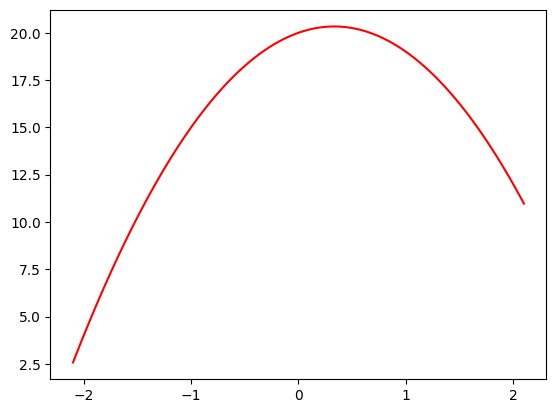

In [9]:
plot_function(f)

In [10]:
import numpy as np

# 生成一维数组，长度为5
a = np.array([1, 2, 3, 4, 5])
print("a shape:", a.shape)  # (5,)

# 给一维数组加一个新维度，变成列向量 (5, 1)
a_col = a[:, None]
print("a_col shape:", a_col.shape)  # (5, 1)

# 给一维数组加一个新维度，变成行向量 (1, 5)
a_row = a[None, :]
print("a_row shape:", a_row.shape)  # (1, 5)

# 直接用一维数组做矩阵乘法会报错
try:
    result = a @ a  # 错误，1D数组不能直接用@乘法
except Exception as e:
    print("a @ a error:", e)

# 使用二维列向量和二维行向量做矩阵乘法，得到正常结果 (5, 5) 矩阵
result = a_col @ a_row
print("a_col @ a_row result shape:", result.shape)
print(result)
'''
好的，给你讲解一下「形状」是什么意思，特别是 `(5,)` 这种写法：

---

### 1. 什么是数组的「形状」（Shape）？

在 NumPy 里，数组（ndarray）是多维数据的集合。形状用一个「元组」表示，告诉你这个数组有多少个维度，每个维度的长度是多少。

举个例子：

* 一维数组，像一条线，形状是 `(5,)` ，表示只有一个维度，长度是 5，也就是有5个元素。
* 二维数组，像一个表格（矩阵），形状可能是 `(3, 4)`，表示有 3 行，4 列。
* 三维数组，形状可能是 `(2, 3, 4)`，就像 2 张 3×4 的表格堆起来。

---

### 2. `(5,)` 和 `(5,1)`、`(1,5)` 的区别

* `(5,)`：一维数组，有5个元素，比如 `[1, 2, 3, 4, 5]`，没有明确的行或列概念，只是5个数字排成一条线。

* `(5,1)`：二维数组，有5行，1列，也就是“列向量”，长这样：

  ```
  [[1],
   [2],
   [3],
   [4],
   [5]]
  ```

* `(1,5)`：二维数组，有1行，5列，也就是“行向量”，长这样：

  ```
  [[1, 2, 3, 4, 5]]
  ```

---

### 3. 为什么要区分这些形状？

很多数学运算，比如矩阵乘法、广播等，都依赖数组的形状，形状不同结果就会不一样，甚至会报错。

举个例子，二维的 `(5,1)` 跟 `(1,5)` 矩阵相乘，能得到一个 5 行 5 列的矩阵，而一维数组 `(5,)` 不能直接做矩阵乘法。

---

### 总结

* 数组的「形状」告诉你数组有几维，每维有多少个元素。
* `(5,)` 是一维数组，5个元素。
* `(5,1)` 是二维数组，5行1列。
* `(1,5)` 是二维数组，1行5列。
* 形状不同，很多运算的规则也不同。

---

你可以把形状想象成「数据的尺寸和排布」！需要我帮你用图形画出来更直观地解释吗？

'''


a shape: (5,)
a_col shape: (5, 1)
a_row shape: (1, 5)
a_col @ a_row result shape: (5, 5)
[[ 1  2  3  4  5]
 [ 2  4  6  8 10]
 [ 3  6  9 12 15]
 [ 4  8 12 16 20]
 [ 5 10 15 20 25]]


For instance, perhaps we've measured the height above ground of an object before and after some event. The measurements will have some random error. We can use numpy's random number generator to simulate that. I like to use `seed` when writing about simulations like this so that I know you'll see the same thing I do:

In [11]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

Here's a function `add_noise` that adds some random variation to an array:

In [12]:
def noise(x, scale):
  return normal(scale=scale, size=x.shape)#scale：一个数值，表示正态分布的标准差（noise 的强度）标准差（std or scale）：数据的波动范围，越大表示数据越分散
def add_noise(x, mult, add):
  return x * (1+noise(x,mult)) + noise(x,add)
'''
当然！我来帮你详细讲解 `add_noise` 这个函数的含义和内部机制。

---

### 函数代码回顾：

```python
def add_noise(x, mult, add):
    return x * (1 + noise(x, mult)) + noise(x, add)
```

---

### 参数说明：

* `x`：输入的原始数据数组（numpy array），比如函数计算得到的理想数据。
* `mult`：乘法噪声的标准差（scale），控制“相对误差”的强度。
* `add`：加法噪声的标准差，控制“绝对误差”的强度。

---

### 函数功能：

这个函数是在给原始数据 `x` 增加噪声（扰动），模拟现实中测量或数据采集时存在的误差。

---

### 具体过程拆解：

1. `noise(x, mult)`

   * 产生一个和 `x` 形状相同的正态分布随机数数组，标准差为 `mult`。
   * 这代表“相对误差”，因为后续会乘到 `x` 上。

2. `1 + noise(x, mult)`

   * 给误差加上 1，表示“以1为基准，上下波动”，比如 1.05 表示在 `x` 上增加5%。

3. `x * (1 + noise(x, mult))`

   * 把这个带随机扰动的比例乘以 `x`，相当于对 `x` 做**比例扰动**。
   * 例如，`x=100`，比例扰动是0.05，则结果是105。

4. `noise(x, add)`

   * 产生另一组正态分布随机噪声，标准差为 `add`，表示**加法误差**，不随 `x` 大小变化。
   * 这就像测量仪器的固定误差，比如温度计误差 ±1度。

5. 最终返回：

   $$
   \text{输出} = x \times (1 + \text{相对误差}) + \text{绝对误差}
   $$

---

### 形象理解：

* `mult` 控制数据的“**比例噪声**”，比如 5% 的波动。
* `add` 控制数据的“**固定噪声**”，比如 ±1 单位的误差。
* 两种误差合起来，更真实地模拟现实中数据测量的复杂情况。

---

### 举例：

假设 `x = 100`，`mult=0.1`（10%比例误差），`add=2`（±2单位误差），一次随机调用可能产生：

* 比例噪声：`noise(x, 0.1)` 生成了 `0.08`，所以乘数是 `1 + 0.08 = 1.08`
* 加法噪声：`noise(x, 2)` 生成了 `-1.5`
* 计算结果是：

  $$
  100 \times 1.08 + (-1.5) = 108 - 1.5 = 106.5
  $$

---

### 总结

* `add_noise` 用两种不同类型的正态分布噪声同时扰动原始数据，
* 更准确地模拟了实际测量和数据采集时可能出现的误差类型。

---

如果你需要，我可以帮你写个小示例代码，直观演示不同参数对数据噪声的影响。你需要吗？

'''

问题一：代码中的每个代码和参数表示什么意思

回答：


```python
def noise(x, scale):
    return normal(scale=scale, size=x.shape)
```

* `def noise(x, scale):`
  定义一个函数，名字叫 `noise`，接收两个参数：

  * `x`：一个数组（numpy array）
  * `scale`：一个数值，表示正态分布的标准差（noise 的强度）

* `normal(scale=scale, size=x.shape)`
  这里调用的是 `numpy.random.normal`，是用来生成正态分布随机数的函数。

  * `scale=scale`：指定正态分布的标准差，控制随机数的波动范围。
  * `size=x.shape`：生成的随机数数组形状与输入数组 `x` 一样大（即对应每个元素产生一个随机数）。
  * 返回值是一个与 `x` 大小相同的正态分布随机数组。

---

```python
def add_noise(x, mult, add):
    return x * (1 + noise(x, mult)) + noise(x, add)
```

* `def add_noise(x, mult, add):`
  定义一个函数，名字叫 `add_noise`，接收三个参数：

  * `x`：原始数据数组
  * `mult`：乘法噪声的标准差参数
  * `add`：加法噪声的标准差参数

* 函数返回值是给原始数据 `x` 加上两种噪声后的结果：

  1. `noise(x, mult)`：调用之前定义的 `noise` 函数，产生与 `x` 同形状的乘法噪声（随机比例扰动）。
  2. `1 + noise(x, mult)`：给乘法噪声加上1，表示在原数据基础上乘以一个接近1的随机因子（比如 1.05 表示增加5%的噪声）。
  3. `x * (1 + noise(x, mult))`：把这个随机因子乘以 `x`，相当于对原数据做比例上的随机扰动。
  4. `noise(x, add)`：产生另外一组加法噪声，模拟固定大小的随机误差。
  5. `x * (1 + noise(x, mult)) + noise(x, add)`：最终返回数据包含比例扰动和固定扰动。

---

```python
x = np.linspace(-2, 2, num=20)[:, None]
```

* `np.linspace(-2, 2, num=20)`：
  生成一个一维数组，包含20个从 -2 到 2 之间等间距的点。

* `[:, None]`：
  这是 numpy 的切片操作，给数组增加一个维度，把一维数组转换成二维的列向量。
  例如原本是一维 `[a, b, c]`，加上 `[:, None]` 后变成 `[[a], [b], [c]]`。
  这样做是为了配合后面函数计算中对形状的要求。

---

```python
y = add_noise(f(x), 0.2, 1.3)
```

* `f(x)`：
  调用之前定义的数学函数 `f`，对 `x` 中的每个元素做数学计算，返回一个新的数组。

* `add_noise(f(x), 0.2, 1.3)`：
  对函数输出的结果加噪声，`0.2` 是乘法噪声的强度，`1.3` 是加法噪声的强度。
  这样得到的 `y` 就是带有“随机误差”的模拟测量数据。

---

```python
plt.scatter(x, y);
```

* `plt.scatter(x, y)`：
  用 matplotlib 画散点图，`x` 是横坐标，`y` 是纵坐标。
  这里用散点图表示每个点的实际取值（带噪声的函数值），能直观看出数据的随机波动。

* 分号 `;` 是可选的，防止 jupyter notebook 输出多余的图形信息。

---

### 总结

| 名称            | 含义               |
| ------------- | ---------------- |
| `normal`      | 生成正态分布随机数        |
| `scale`       | 正态分布标准差，控制随机数幅度  |
| `size`        | 生成随机数组大小         |
| `noise`       | 产生与输入形状相同的随机噪声   |
| `add_noise`   | 叠加乘法噪声和加法噪声的函数   |
| `np.linspace` | 生成等间距数值序列        |
| `[:, None]`   | 给数组增加维度，把行向量转列向量 |
| `plt.scatter` | 画散点图             |

---

如果你还想，我可以帮你写一个完整的小例子代码，方便你直接运行体验和观察效果。需要吗？
问题二：正态分布的随机数

回答：满足钟型分布的函数
好的，我帮你解释一下**正态分布的随机数**是什么：

---

### 1. **什么是正态分布？**

正态分布（Normal Distribution），也叫高斯分布，是统计学里最重要的一种概率分布。

* 它的形状像一个对称的“钟形曲线”，
* 数据点大多数集中在平均值附近，
* 离平均值越远的数出现概率越低。

比如：人的身高、考试成绩、测量误差等自然现象，很多都会近似服从正态分布。

---

### 2. **正态分布的随机数是什么？**

* 计算机生成的随机数不一定是均匀分布的（每个数出现概率一样），
* 通过特定算法可以生成满足正态分布规律的随机数，称为**正态分布随机数**。

---

### 3. **为什么要用正态分布随机数？**

* 模拟现实中很多带有自然波动或误差的现象，
* 生成符合现实规律的随机样本，进行统计分析、建模或测试。

---

### 4. **正态分布随机数的参数**

正态分布随机数主要由两个参数决定：

* **均值（mean）**：数据的平均位置
* **标准差（std or scale）**：数据的波动范围，越大表示数据越分散

---

### 5. **举个例子**

```python
import numpy as np
# 生成1000个均值为0，标准差为1的正态分布随机数
data = np.random.normal(loc=0, scale=1, size=1000)
```

这段代码生成的随机数是：

* 平均值大约接近 0，
* 大部分数据集中在 -3 到 3 之间，
* 形成典型的钟形曲线。

---

### 总结

**正态分布的随机数**就是“符合正态分布概率特征”的随机数，用于模拟和处理真实世界中普遍存在的随机波动和误差。

---

举一个简单的例子：
好的，我帮你详细讲解一下：

`size=x.shape` 是用在生成随机数函数里的一个参数，意思是“生成一个和 `x` 形状（shape）一样的随机数数组”。

具体来说：

1. **x.shape 是什么？**

   * `x` 是一个数组（numpy array），它有自己的维度和大小。
   * 例如：如果 `x` 是一维数组 `[1, 2, 3, 4, 5]`，那么 `x.shape` 就是 `(5,)`，表示这个数组有5个元素。
   * 如果是二维数组，比如 `[[1, 2], [3, 4]]`，`x.shape` 就是 `(2, 2)`，表示有2行2列。

2. **size 参数在生成随机数函数中的作用**

   * 当我们调用 `normal(scale=scale, size=x.shape)`，这个函数会生成一个服从正态分布的随机数数组，
   * 这个随机数数组的形状（行数和列数）和 `x` 一模一样。
   * 这样就保证每个 `x` 中的元素都会对应一个随机数。

3. **为什么要这么做？**

   * 在你之前的代码 `add_noise` 里，你是给数组 `x` 的每个元素都加上了一个随机扰动，
   * 如果生成的随机数数组形状和 `x` 不匹配，没法逐元素对应相加。
   * 所以需要保证随机数数组和输入的 `x` 一样大。

---

### 举个简单的例子

```python
import numpy as np

x = np.array([10, 20, 30])
print("x.shape =", x.shape)  # 输出 (3,)

random_noise = np.random.normal(scale=1, size=x.shape)
print("random_noise =", random_noise)
```

输出可能是：

```
x.shape = (3,)
random_noise = [0.5, -1.2, 0.3]
```

这样 `random_noise` 数组有3个随机数，和 `x` 数量一样，可以对应每个元素做加法。

---
标准差越大，正态分布的钟型曲线会变得越“扁平”和“宽广”，也就是说：

数据点离平均值的距离变得更大，分布范围更广，

集中在平均值附近的数据比例减少，

钟形曲线的峰值（最高点）降低，整体看起来“矮胖”了。

反之，标准差越小，数据越集中，钟形曲线越“尖”，峰值越高。

你可以把标准差想象成数据的“波动幅度”，波动越大，数据越分散。





Let's use it to simulate some measurements evenly distributed over time:

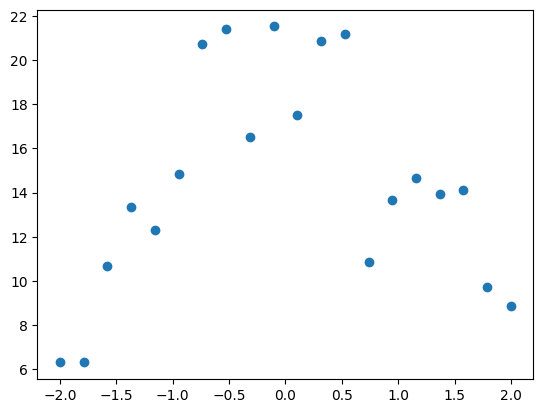

In [13]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

Now let's see what happens if we *underfit* or *overfit* these predictions. To do that, we'll create a function that fits a polynomial of some degree (e.g. a line is degree 1, quadratic is degree 2, cubic is degree 3, etc). The details of how this function works don't matter too much so feel free to skip over it if you like!  (PS: if you're not sure about the jargon around polynomials, here's a [great video](https://www.youtube.com/watch?v=ffLLmV4mZwU) which teaches you what you'll need to know.)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

So, what happens if we fit a line (a "degree 1 polynomial") to our measurements?

In [ ]:
plot_poly(1)

As you see, the points on the red line (the line we fitted) aren't very close at all. This is *under-fit* -- there's not enough detail in our function to match our data.

And what happens if we fit a degree 10 polynomial to our measurements?

In [ ]:
plot_poly(10)

Well now it fits our data better, but it doesn't look like it'll do a great job predicting points other than those we measured -- especially those in earlier or later time periods. This is *over-fit* -- there's too much detail such that the model fits our points, but not the underlying process we really care about.

Let's try a degree 2 polynomial (a quadratic), and compare it to our "true" function (in blue):

In [ ]:
plot_poly(2)
plot_function(f, color='b')

That's not bad at all!

So, how do we recognise whether our models are under-fit, over-fit, or "just right"? We use a *validation set*. This is a set of data that we "hold out" from training -- we don't let our model see it at all. If you use the fastai library, it automatically creates a validation set for you if you don't have one, and will always report metrics (measurements of the accuracy of a model) using the validation set.

The validation set is *only* ever used to see how we're doing. It's *never* used as inputs to training the model.

Transformers uses a `DatasetDict` for holding your training and validation sets. To create one that contains 25% of our data for the validation set, and 75% for the training set, use `train_test_split`:

In [ ]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

As you see above, the validation set here is called `test` and not `validate`, so be careful!

In practice, a random split like we've used here might not be a good idea -- here's what Dr Rachel Thomas has to say about it:

> "*One of the most likely culprits for this disconnect between results in development vs results in production is a poorly chosen validation set (or even worse, no validation set at all). Depending on the nature of your data, choosing a validation set can be the most important step. Although sklearn offers a `train_test_split` method, this method takes a random subset of the data, which is a poor choice for many real-world problems.*"

I strongly recommend reading her article [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/) to more fully understand this critical topic.

### Test set

So that's the validation set explained, and created. What about the "test set" then -- what's that for?

The *test set* is yet another dataset that's held out from training. But it's held out from reporting metrics too! The accuracy of your model on the test set is only ever checked after you've completed your entire training process, including trying different models, training methods, data processing, etc.

You see, as you try all these different things, to see their impact on the metrics on the validation set, you might just accidentally find a few things that entirely coincidentally improve your validation set metrics, but aren't really better in practice. Given enough time and experiments, you'll find lots of these coincidental improvements. That means you're actually over-fitting to your validation set!

That's why we keep a test set held back. Kaggle's public leaderboard is like a test set that you can check from time to time. But don't check too often, or you'll be even over-fitting to the test set!

Kaggle has a *second* test set, which is yet another held-out dataset that's only used at the *end* of the competition to assess your predictions. That's called the "private leaderboard". Here's a [great post](https://gregpark.io/blog/Kaggle-Psychopathy-Postmortem/) about what can happen if you overfit to the public leaderboard.

We'll use `eval` as our name for the test set, to avoid confusion with the `test` dataset that was created above.

In [ ]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

## Metrics and correlation

When we're training a model, there will be one or more *metrics* that we're interested in maximising or minimising. These are the measurements that should, hopefully, represent how well our model will works for us.

In real life, outside of Kaggle, things not easy... As my partner Dr Rachel Thomas notes in [The problem with metrics is a big problem for AI](https://www.fast.ai/2019/09/24/metrics/):

>  At their heart, what most current AI approaches do is to optimize metrics. The practice of optimizing metrics is not new nor unique to AI, yet AI can be particularly efficient (even too efficient!) at doing so. This is important to understand, because any risks of optimizing metrics are heightened by AI. While metrics can be useful in their proper place, there are harms when they are unthinkingly applied. Some of the scariest instances of algorithms run amok all result from over-emphasizing metrics. We have to understand this dynamic in order to understand the urgent risks we are facing due to misuse of AI.

In Kaggle, however, it's very straightforward to know what metric to use: Kaggle will tell you! According to this competition's [evaluation page](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/overview/evaluation), "*submissions are evaluated on the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between the predicted and actual similarity scores*." This coefficient is usually abbreviated using the single letter *r*. It is the most widely used measure of the degree of relationship between two variables.

r can vary between `-1`, which means perfect inverse correlation, and `+1`, which means perfect positive correlation. The mathematical formula for it is much less important than getting a good intuition for what the different values look like. To start to get that intuition, let's look at some examples using the [California Housing](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) dataset, which shows "*is the median house value for California districts, expressed in hundreds of thousands of dollars*". This dataset is provided by the excellent [scikit-learn](https://scikit-learn.org/stable/) library, which is the most widely used library for machine learning outside of deep learning.

In [ ]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

We can see all the correlation coefficients for every combination of columns in this dataset by calling `np.corrcoef`:

In [ ]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

This works well when we're getting a bunch of values at once, but it's overkill when we want a single coefficient:

In [ ]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

Therefore, we'll create this little function to just return the single number we need given a pair of variables:

In [ ]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

Now we'll look at a few examples of correlations, using this function (the details of the function don't matter too much):

In [ ]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

OK, let's check out the correlation between income and house value:

In [ ]:
show_corr(housing, 'MedInc', 'MedHouseVal')

So that's what a correlation of 0.68 looks like. It's quite a close relationship, but there's still a lot of variation. (Incidentally, this also shows why looking at your data is so important -- we can see clearly in this plot that house prices above $500,000 seem to have been truncated to that maximum value).

Let's take a look at another pair:

In [ ]:
show_corr(housing, 'MedInc', 'AveRooms')

The relationship looks like it is similarly close to the previous example, but r is much lower than the income vs valuation case. Why is that? The reason is that there are a lot of *outliers* -- values of `AveRooms` well outside the mean.

r is very sensitive to outliers. If there's outliers in your data, then the relationship between them will dominate the metric. In this case, the houses with a very high number of rooms don't tend to be that valuable, so it's decreasing r from where it would otherwise be.

Let's remove the outliers and try again:

In [ ]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

As we expected, now the correlation is very similar to our first comparison.

Here's another relationship using `AveRooms` on the subset:

In [ ]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

At this level, with r of 0.34, the relationship is becoming quite weak.

Let's look at one more:

In [ ]:
show_corr(subset, 'HouseAge', 'AveRooms')

As you see here, a correlation of -0.2 shows a very weak negative trend.

We've seen now examples of a variety of levels of correlation coefficient, so hopefully you're getting a good sense of what this metric means.

Transformers expects metrics to be returned as a `dict`, since that way the trainer knows what label to use, so let's create a function to do that:

In [ ]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

## Training

## Training our model

To train a model in Transformers we'll need this:

In [ ]:
from transformers import TrainingArguments,Trainer

We pick a batch size that fits our GPU, and small number of epochs so we can run experiments quickly:

In [ ]:
bs = 128
epochs = 4

The most important hyperparameter is the learning rate. fastai provides a learning rate finder to help you figure this out, but Transformers doesn't, so you'll just have to use trial and error. The idea is to find the largest value you can, but which doesn't result in training failing.

In [ ]:
lr = 8e-5

Transformers uses the `TrainingArguments` class to set up arguments. Don't worry too much about the values we're using here -- they should generally work fine in most cases. It's just the 3 parameters above that you may need to change for different models.

In [ ]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

We can now create our model, and `Trainer`, which is a class which combines the data and model together (just like `Learner` in fastai):

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

As you see, Transformers spits out lots of warnings. You can safely ignore them.

Let's train our model!

In [ ]:
trainer.train();

Lots more warning from Transformers again -- you can ignore these as before.

The key thing to look at is the "Pearson" value in table above. As you see, it's increasing, and is already above 0.8. That's great news! We can now submit our predictions to Kaggle if we want them to be scored on the official leaderboard. Let's get some predictions on the test set:

In [ ]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

Look out - some of our predictions are <0, or >1! This once again shows the value of remember to actually *look* at your data. Let's fix those out-of-bounds predictions:

In [ ]:
preds = np.clip(preds, 0, 1)

In [ ]:
preds

OK, now we're ready to create our submission file. If you save a CSV in your notebook, you will get the option to submit it later.

In [ ]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Unfortunately this is a *code competition* and internet access is disabled. That means the `pip install datasets` command we used above won't work if you want to submit to Kaggle. To fix this, you'll need to download the pip installers to Kaggle first, as [described here](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/113195). Once you've done that, disable internet in your notebook, go to the Kaggle leaderboards page, and click the *Submission* button.

## The end

Once you're ready to go deeper, take a look at my [Iterate Like a Grandmaster](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/) notebook.

Thanks for reading! This has been a bit of an experiment for me -- I've never done an "absolute beginners" guide before on Kaggle. I hope you like it! If you do, I'd greatly appreciate an upvote. Don't hesitate to add a comment if you have any questions or thoughts to add.